In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import os

In [3]:
data_dir = r'C:/Users/ding/Documents/WenyuAnalysis/WenyuAnalysis/data/final'   # your data directory
file_list = ['1925_water_pointevent_291124.csv','1891_water_pointevent_291124.csv','1866_water_pointevent_291124.csv','3141_water_pointevent_201124.csv','2099_water_pointevent_201124.csv','2021_water_pointevent_201124.csv','3152_water_pointevent_201124.csv','2015_water_pointevent_111124.csv','2107_water_pointevent_111124.csv','2023_water_pointevent_111124.csv','3118_water_pointevent_111124.csv','2097_water_pointevent_111124.csv',
             '2097_chocolate_061224.csv','1925_chocolate_pointevent_291124.csv','1891_chocolate_pointevent_291124.csv','1866_chocolate_pointevent_291124.csv','3141_chocolate_pointevent_201124.csv','2021_chocolate_pointevent_201124.csv','3118_chocolate_pointevent_201124.csv','2099_chocolate_pointevent_111124.csv','2107_chocolate_pointevent_111124.csv','2015_chocolate_pointevent_111124.csv','3152_chocolate_pointevent_111124.csv','2023_chocolate_pointevent_201124.csv',
             '1925_strawberry_pointevent_291124.csv','1891_strawberry_pointevent_291124.csv','1866_strawberry_pointevent_291124.csv','3141_strawberry_pointevent_201124.csv','2099_strawberry_pointevent_111124.csv','2097_strawberry_pointevent_111124.csv','3118_strawberry_pointevent_111124.csv','2023_strawberry_pointevent_111124.csv','2107_strawberry_pointevent_111124.csv','2021_strawberry_pointevent_111124.csv','3152_strawberry_pointevent_111124.csv','2015_strawberry_pointevent_201124.csv',
             '1925_vanilla_pointevent_291124.csv','1891_vanilla_pointevent_291124.csv','1866_vanilla_pointevent_291124.csv','3141_vanilla_pointevent_201124.csv','2015_vanilla_pointevent_111124.csv','3152_vanilla_pointevent_201124.csv','2021_vanilla_pointevent_111124.csv','2107_vanilla_pointevent_111124.csv','2099_vanilla_pointevent_111124.csv','2023_vanilla_pointevent_111124.csv','3118_vanilla_pointevent_111124.csv','2097_vanilla_pointevent_111124.csv',
             '2097_quinine_061224.csv','1925_quinine_pointevent_291124.csv','1891_quinine_pointevent_291124.csv','1866_quinine_pointevent_291124.csv','3141_quinine_pointevent_201124.csv','2015_quinine_pointevent_201124.csv','3152_quinine_pointevent_201124.csv','2107_quinine_pointevent_111124.csv','2099_quinine_pointevent_111124.csv','2023_quinine_pointevent_111124.csv','3118_quinine_pointevent_111124.csv','2021_quinine_pointevent_111124.csv']  # list of file names

In [4]:
import os
import pandas as pd

# Function to restructure data and calculate Z-scores
def restructure_data_with_zscore(data):
    """
    Restructure the data to create a merged table where each column corresponds to a neuron 
    or an experimental variable and each row corresponds to a time point. Also calculates Z-scores.
    """
    data_group = data.groupby('Cell')
    template_df = None
    for k in data_group.groups.keys():
        if template_df is None:
            template_df = data_group.get_group(k)
            template_df = template_df.drop(columns=['F', 'Cell'])
        cell_id = int(''.join(filter(str.isdigit, k)))
        template_df[cell_id] = data_group.get_group(k)['F'].values
        
    
    # Calculate Z-scores for each neuron column
    neuron_columns = [col for col in template_df.columns if isinstance(col, int)]
    for col in neuron_columns:
        mean = template_df[col].mean()
        std = template_df[col].std()
        template_df[col] = (template_df[col] - mean) / std  # Replace with Z-scores
    return template_df


# Function to batch-load and process files
def process_files_with_zscore(data_dir, file_list):
    """
    Batch load and process files to add mouse number, condition, and calculate Z-scores.
    """
    processed_data = []

    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)
        
        # Extract mouse number and condition from file name
        parts = file_name.split('_')
        mouse_number = parts[0]
        condition = parts[1]
        
        # Load the file
        data = pd.read_csv(file_path)
        
        # Restructure the data with Z-scores
        restructured_data = restructure_data_with_zscore(data)
        
        # Add mouse number and condition as columns
        restructured_data['Mouse'] = mouse_number
        restructured_data['Condition'] = condition
        
        # Append to the list
        processed_data.append(restructured_data)
    
    # Concatenate all processed data into a single DataFrame
    merged_data = pd.concat(processed_data, ignore_index=True)
    return merged_data

# Define directory and file list

# Process files and create the merged DataFrame with Z-scores
merged_data_with_zscore = process_files_with_zscore(data_dir, file_list)

# Save the merged data with Z-scores to a new CSV file (optional)
output_path = os.path.join(data_dir, 'merged_data_with_zscore.csv')
merged_data_with_zscore.to_csv(output_path, index=False)

print("Data restructuring with Z-scores completed!")


Data restructuring with Z-scores completed!


In [5]:
import pandas as pd

def assign_event_index_per_group(df, event_column='lickpoint', group_columns=['Mouse', 'Condition']):
    """
    Assigns an incremental event index starting from 1 for each group of mouse and condition.
    
    Parameters:
        df (pd.DataFrame): The dataset containing time series data.
        event_column (str): The column indicating events (e.g., 1 for event occurrence).
        group_columns (list): Columns to group by (e.g., Mouse, Condition).
        
    Returns:
        pd.DataFrame: DataFrame with an added 'Event_Index' column.
    """
    # Initialize the 'Event_Index' column as NaN
    df['Event_Index'] = None

    # Group by Mouse and Condition
    for _, group_data in df.groupby(group_columns):
        # Find the indices where the event occurs (event_column == 1)
        event_indices = group_data[group_data[event_column] == 1].index
        #print(event_indices)
        # Assign event index starting from 1 for each event occurrence in the group
        df.loc[event_indices, 'Event_Index'] = range(1, len(event_indices) + 1)
        
        # Forward fill Event_Index to ensure all rows within the same group have the same Event_Index
        #df['Event_Index'] = df['Event_Index'].ffill()

    return df

# Example usage:
# Assume 'merged_data_with_zscore' is the restructured data with Z-scores calculated.
# The 'bitepoint' column is used to mark events.
# The dataframe should contain 'Mouse' and 'Condition' columns, as well as an event marker column (e.g., 'bitepoint').

# Sample Data (make sure to replace this with your actual data):
# merged_data_with_zscore = pd.DataFrame({
#     'Mouse': ['Mouse1', 'Mouse1', 'Mouse2', 'Mouse2'],
#     'Condition': ['Condition1', 'Condition1', 'Condition2', 'Condition2'],
#     'bitepoint': [0, 1, 0, 1],
#     'Other_Column': [0.5, 0.7, 0.6, 0.8]
# })

# Apply the event index assignment
merged_data_with_zscore = assign_event_index_per_group(merged_data_with_zscore, event_column='lickpoint', group_columns=['Mouse', 'Condition'])

# Check the output
print(merged_data_with_zscore)


C:\Users\ding\AppData\Local\Temp\ipykernel_25356\3741843393.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Event_Index'] = None


              Time  lick  lickpoint  licking         0         1         3  \
0         0.099918   0.0        0.0      NaN -0.060669 -0.042496 -0.133489   
1         0.199836   0.0        0.0      NaN -0.060669 -0.042496 -0.133489   
2         0.299754   0.0        0.0      NaN -0.060669 -0.042496 -0.133489   
3         0.399672   0.0        0.0      NaN -0.060669 -0.042496 -0.133489   
4         0.499590   0.0        0.0      NaN -0.060669 -0.042496 -0.133489   
...            ...   ...        ...      ...       ...       ...       ...   
188094  305.655552   NaN        0.0      0.0 -1.113623       NaN  1.032344   
188095  305.755472   NaN        0.0      0.0 -1.220768       NaN  1.581055   
188096  305.855392   NaN        0.0      0.0 -1.406222       NaN  1.626263   
188097  305.955312   NaN        0.0      0.0 -1.207881       NaN  1.840058   
188098  306.055232   NaN        0.0      0.0 -1.239751       NaN  1.710422   

               4         5         6  ...  106  143  161  163  

In [6]:
import pandas as pd


def extract_event_windows(data, event_column='lickpoint', pre_event_time=30, post_event_time=30):
    """
    Extracts pre-event and post-event data around specified events from the dataset.
    
    Parameters:
        data (pd.DataFrame): The restructured dataset with time series data.
        event_column (str): The column indicating events (e.g., 1 for event occurrence).
        pre_event_time (int): Number of time points before the event to include.
        post_event_time (int): Number of time points after the event to include.
    
    Returns:
        pd.DataFrame: A DataFrame containing the extracted data with additional metadata.
    """
    # Ensure the event column exists
    if event_column not in data.columns:
        raise ValueError(f"The specified event column '{event_column}' does not exist in the data.")
    
    # Find all event indices
    event_indices = data[data[event_column] == 1].index

    # Initialize a list to store results
    event_data = []

    for event_index in event_indices:
        # Define the window around the event
        start_time = event_index - pre_event_time
        end_time = event_index + post_event_time

        # Ensure the window is within bounds
        if start_time < 0 or end_time >= len(data):
            continue

        # Extract data for the time window
        window_data = data.iloc[start_time:end_time + 1]  # Use .iloc to slice by row index

        # Add metadata for the event
        window_data = window_data.copy()
        window_data['Time_Relative_to_Event'] = range(-pre_event_time, post_event_time + 1)

        # Append to the list
        event_data.append(window_data)

    # Combine all event windows into a single DataFrame
    event_windows_df = pd.concat(event_data, ignore_index=True)
    return event_windows_df

# Example usage:


# Step 2: Extract event windows for each event (e.g., lick events)
pre_event_time = 30
post_event_time = 30

event_windows = extract_event_windows(
    data=merged_data_with_zscore,
    event_column='lickpoint',  # Adjust as per your event column
    pre_event_time=pre_event_time,
    post_event_time=post_event_time
)

# Save the extracted data to a CSV file (optional)
event_windows.to_csv('event_windows_data.csv', index=False)

print("Pre-event and post-event data extraction completed!")


Pre-event and post-event data extraction completed!


In [24]:
event_windows

,Time,lick,lickpoint,licking,0,1,3,4,5,6,...,143,161,163,165,167,175,178,181,Event_Index,Time_Relative_to_Event
0,57.153096,0.0,0.0,NaN,-0.060669,-0.042496,-0.133489,-0.025093,-0.055536,-0.079279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,-30
1,57.253014,0.0,0.0,NaN,-0.060669,-0.042496,-0.133489,-0.025093,-0.055536,-0.079279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,-29
2,57.352932,0.0,0.0,NaN,-0.060669,-0.042496,-0.133489,-0.025093,-0.055536,-0.079279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,-28
3,57.452850,0.0,0.0,NaN,-0.060669,-0.042496,-0.133489,-0.025093,-0.055536,-0.079279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,-27
4,57.552768,0.0,0.0,NaN,-0.060669,-0.042496,-0.133489,-0.025093,-0.055536,-0.079279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,302.358189,NaN,0.0,0.0,-0.485360,NaN,0.954036,6.716903,NaN,4.896764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,26
24030,302.458109,NaN,0.0,0.0,-1.820966,NaN,1.172918,3.588443,NaN,5.734826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,27
24031,302.558029,NaN,0.0,0.0,-1.827153,NaN,1.436302,3.142967,NaN,6.297094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,28
24032,302.657949,NaN,0.0,0.0,-1.754389,NaN,1.071613,2.461635,NaN,5.795681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,29


C:\Users\ding\AppData\Local\Temp\ipykernel_25356\2871360738.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


Plot saved to event_visualization.png


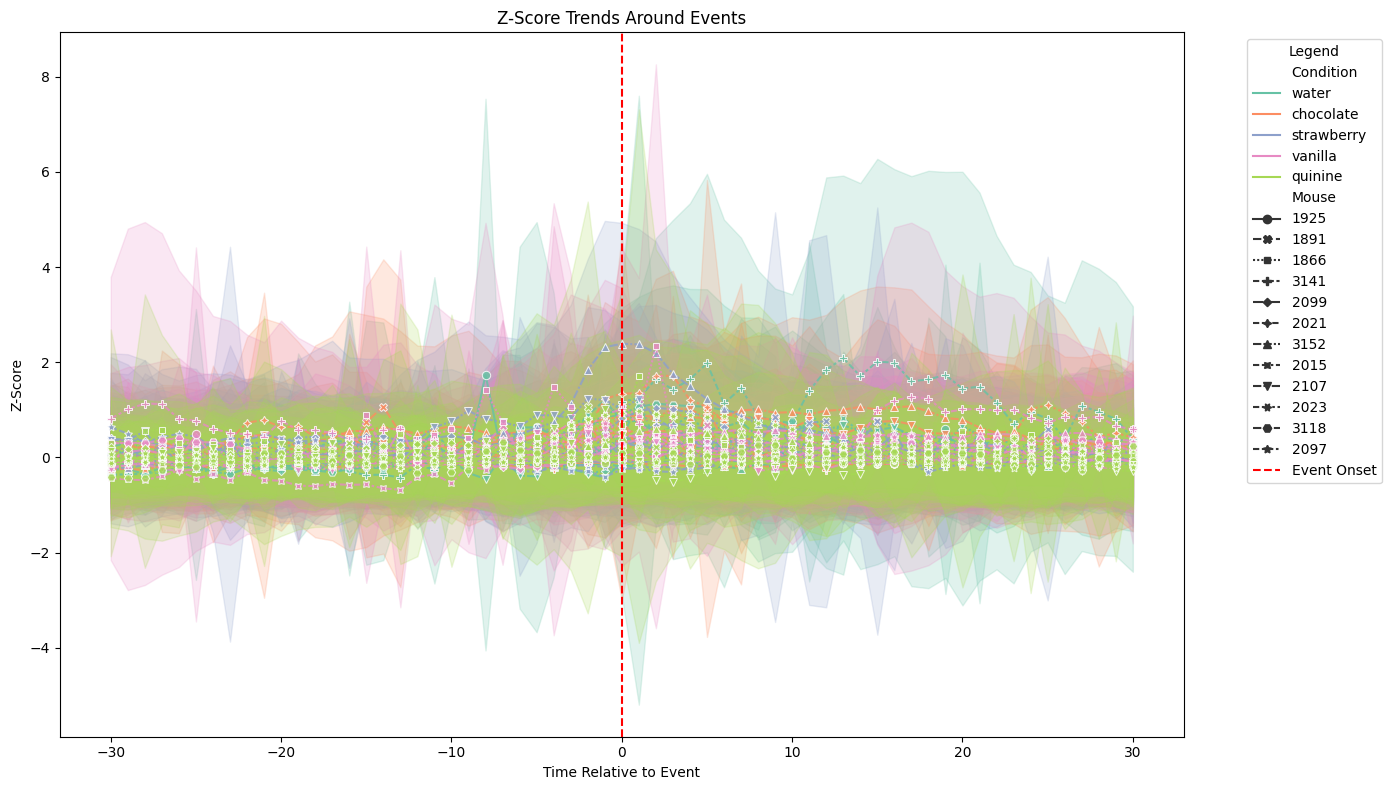

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_event_data(event_data, mouse_column='Mouse', condition_column='Condition', 
                         event_column='Event_Index', zscore_columns=None, save_path=None):
    """
    Visualize the event data by showing mouse, condition, event, and z-score.

    Parameters:
        event_data (pd.DataFrame): The extracted event data.
        mouse_column (str): Column indicating the mouse number.
        condition_column (str): Column indicating the condition.
        event_column (str): Column indicating the event index.
        zscore_columns (list): List of columns with Z-scores for neurons.
        save_path (str): Optional path to save the plot.
    """
    if zscore_columns is None:
        # Automatically identify Z-score columns (assuming numeric neuron columns)
        zscore_columns = [col for col in event_data.columns if isinstance(col, int) or col.isdigit()]

    # Melt the data for visualization
    melted_data = event_data.melt(
        id_vars=[mouse_column, condition_column, event_column, 'Time_Relative_to_Event'],
        value_vars=zscore_columns,
        var_name='Neuron',
        value_name='Z-Score'
    )

    # Plot using seaborn
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=melted_data,
        x='Time_Relative_to_Event',
        y='Z-Score',
        hue=condition_column,
        style=mouse_column,
        ci='sd',
        markers=True,
        palette='Set2',
        alpha=0.8
    )
    plt.axvline(0, color='red', linestyle='--', label='Event Onset')  # Event onset line
    plt.title('Z-Score Trends Around Events')
    plt.xlabel('Time Relative to Event')
    plt.ylabel('Z-Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')
    plt.tight_layout()

    # Save the plot if a path is specified
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()

# Example usage:
# Assume `event_windows` is the DataFrame with extracted event data.
#event_windows['Mouse'] = event_windows['Event_Index'] % 5 + 1  # Example mouse column
#event_windows['Condition'] = ['Condition_' + str(i % 3) for i in event_windows['Event_Index']]  # Example condition column

visualize_event_data(
    event_data=event_windows,
    mouse_column='Mouse',
    condition_column='Condition',
    event_column='Event_Index',
    save_path='event_visualization.png'
)


NameError: name 'data_list' is not defined